<a href="https://colab.research.google.com/github/LuciusMelillo09/DataScience/blob/main/Unit5/Luci_MeliU5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install "preliz"


In [29]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
from matplotlib import pyplot as plt
import seaborn as sns
import graphviz as gv
import xarray as xr

In [30]:
from scipy.interpolate import PchipInterpolator

# Introduction
In this project, I will be using a dataset on FC Barcelona's last 122 matches played, and I will be finding out if the %Posession (how often Barcelona has control of the ball) has a significant effect the amount of goals they score.

In [31]:
url_barca = 'https://raw.githubusercontent.com/LuciusMelillo09/DataScience/refs/heads/main/Unit5/barca_newdataset%20(1).csv'
barca = pd.read_csv(url_barca)

In [32]:
barca

,MATCH_ID,DATE,COMPETITION,ROUND,HOME_OR_AWAY,OPPONENT,GOALS_SCORED,GOALS_CONCEDED,POSSESSION,SHOTS_ON_TARGET,PASS_ACCURACY,EXPECTED_GOALS,MATCH_OUTCOME
0,1,04-01-2023,Copa del Rey,Round of 32,Away,Intercity,4,3,77%,10,90%,2.6,Win
1,2,08-01-2023,La Liga,Matchweek 16,Away,Atletico Madrid,1,0,58%,2,85%,0.7,Win
2,3,12-01-2023,Supercopa,Semi finals,Away,Real Betis,2,2,61%,6,87%,1.2,Draw
3,4,15-01-2023,Supercopa,Finals,Away,Real Madrid,3,1,54%,6,90%,1.9,Win
4,5,19-01-2023,Copa del Rey,Round of 16,Away,AD Ceuta,5,0,65%,7,91%,2.7,Win
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,118,29-01-2025,UCL,League Phase,Home,Atalanta,2,2,67%,7,90%,2.4,Draw
118,119,02-02-2025,La liga,Matchweek 22,Home,Alaves,1,0,69%,4,87%,1.1,Win
119,120,06-02-2025,Copa del Rey,Quarter finals,Away,Valencia,5,0,77%,9,82%,2.7,Win
120,121,09-02-2025,La liga,Matchweek 23,Away,Sevilla,4,1,60%,6,84%,1.9,Win


<Axes: xlabel='POSSESSION', ylabel='GOALS_SCORED'>

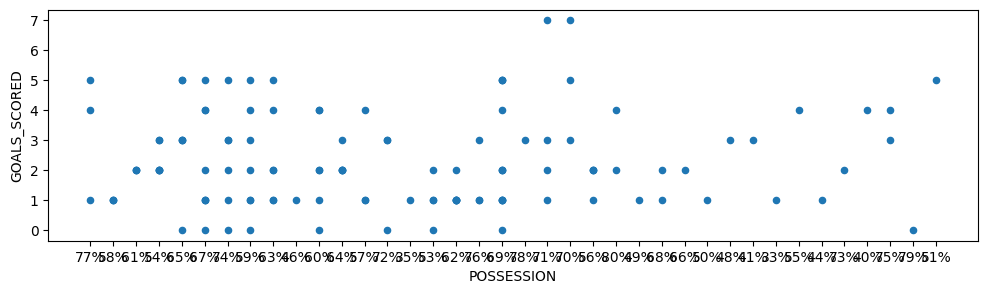

In [33]:
barca.plot(x="POSSESSION",y="GOALS_SCORED", figsize=(12, 3), kind="scatter")

I used Gemini to fix some issues I was running into in the code block below.

In [34]:
barca = pd.read_csv(url_barca)
barca['POSSESSION'] = barca['POSSESSION'].str.replace('%', '').astype(float) / 100

with pm.Model() as model_barca:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * barca['POSSESSION'])

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=barca['GOALS_SCORED'])

    #inference data object
    idata_barca = pm.sample()

Output()

Text(0, 0.5, 'Goals Scored')

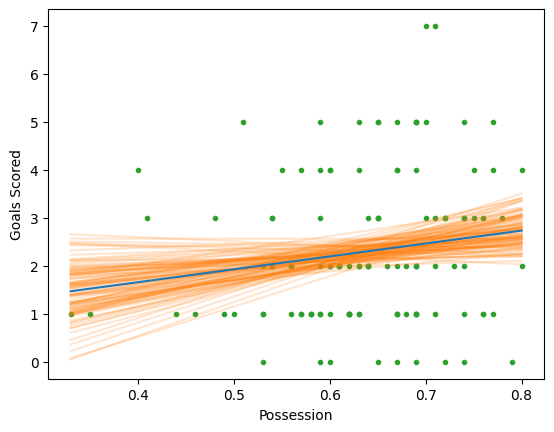

In [35]:
#grabs 100 posterior samples - used Gemini here to fix - suggested change from "POSSESSION" to "barca['POSSESSION']""
posterior = az.extract(idata_barca, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(barca['POSSESSION'].min(), barca['POSSESSION'].max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(barca['POSSESSION'], barca['GOALS_SCORED'], "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Possession")
ax.set_ylabel("Goals Scored")

In [36]:
pm.sample_posterior_predictive(idata_barca, model=model_barca,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

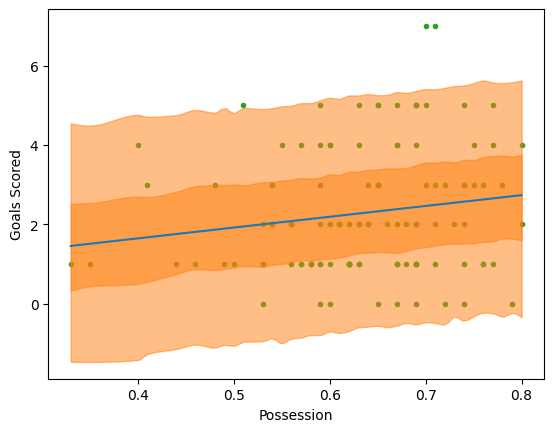

In [37]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_barca.posterior["μ"].mean(("chain", "draw"))

idx = np.argsort(barca['POSSESSION']) # GEMINI Corrected: sort by POSSESSION
x_hdi_plot = np.linspace(barca['POSSESSION'].min(), barca['POSSESSION'].max(), 100) # Corrected: x-range for plot based on POSSESSION, using more points for smoother curve

# GEMINI - Convert the pandas Series of indices to a numpy array for consistent indexing
idx_np = idx.values

#grabs the 94% HDI and 50% HDI
y_pred_q = idata_barca.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

# GEMINI -  fixed PchipInterpolator to ensure strictly increasing x
x_interp_unsorted = barca['POSSESSION'].values
y_interp_unsorted = y_pred_q.values # shape (4, num_data_points)

# Create a temporary DataFrame for grouping to handle duplicate x-values
temp_interp_df = pd.DataFrame({'x_val': x_interp_unsorted})
for i in range(y_interp_unsorted.shape[0]):
    temp_interp_df[f'y_val_{i}'] = y_interp_unsorted[i, :]

# GEMINI - got rid of the issue of duplicated values, because that was causing issues with PchipInterpolator
grouped_interp = temp_interp_df.groupby('x_val').mean().reset_index()
x_for_pchip = grouped_interp['x_val'].values
y_for_pchip_quantiles = [grouped_interp[f'y_val_{i}'].values for i in range(y_interp_unsorted.shape[0])]

#sets up the HDIs for graphing
y_hat_bounds = iter(
    [
        PchipInterpolator(x_for_pchip, y_for_pchip_quantiles[i])(x_hdi_plot)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(barca['POSSESSION'], barca['GOALS_SCORED'], "C2.", zorder=-3) # Corrected: plot POSSESSION vs GOALS_SCORED
ax.plot(barca['POSSESSION'].values[idx_np], mean_line.values[idx_np], c="C0") # Corrected: plot sorted POSSESSION vs sorted mean_line


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x_hdi_plot, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Possession") # Corrected label
ax.set_ylabel("Goals Scored") # Corrected label
plt.show()

<Axes: xlabel='y_pred'>

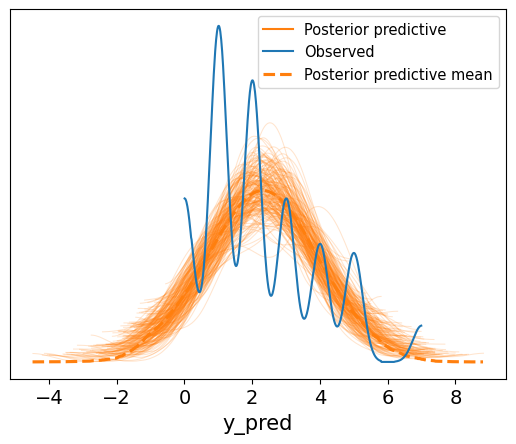

In [38]:
az.plot_ppc(idata_barca, num_pp_samples=200, colors=["C1", "C0", "C1"])

# Conclusion
In conclusion, there is a slight trend of Possession affecting the amount of Goals Scored. This does make sense though, as when a team has the ball for more of the game, it's more likely they'll be able to score. One thing I could do to make the posterior predictive check better is to change my model from a Normal distribution to a Negative Binomial distribution, to better account for the discrete data.